## Description of the problem

In [2]:
# The objective of this project is to implement a framework where the knowedge of bayesian uncertainty can be combined with Deep Learning Models
# The original idea of incorporating bayesian statistics in deep learning models was proposed by Yarin Gal (2016), and here we shall implement that concept utilising the capability of dropout layers to add uncertainty to the model outcome during testing
# The data for this project has been downloaded from https://www.isic-archive.com/#!/topWithHeader/wideContentTop/main
# This is an image data set comprising of malignant and non-malignant skin cancers, and has both binary (Melanoma/Other) as well as multi-class classification labels
# For the purpose of this project, we will use binary labels and assess the change in accuracy of the model for scenarios where the model can predict the outcome witout uncertainty, v/s when the model declares its uncertainty about the outcome
# We have developed our own custom model, and have also assessed the performance of three transfer learning models: MobileNet, DenseNet and NASNet
# We finally used DenseNet201 on the Test Sample and for incorporating the uncertainty, because it was performing the best on training and validation data 

## Environment

In [1]:
# We utilised Google's cloud platform (https://cloud.google.com) to develop our models, test and train them
# The first step was to import the image data set and the .csv file containing the image labels to the working directory
# Once the folder containing image files (ISIC_2019_Training_Input) and the .csv file containing the image labels (ISIC_2019_Training_GroundTruth.csv) have been imported to the working directory, the following code would first create data frame containing binary labels for the corresponding image filenames
# These filenames are then used by the image generator to load random samples of images for test and validation from the working directory, and the binary labels are used from the labels created earlier for training and testing

## Importing the Required Libraries

In [4]:
#Importing Utilities
import os
from glob import glob
import copy
import os
import time
import datetime
from PIL import Image
import sys
import warnings
warnings.filterwarnings("ignore")
import json,codecs

# data tools
import numpy as np
import pandas as pd
from tensorflow.keras.preprocessing.image import ImageDataGenerator
import tqdm

# visualization
import seaborn as sns
import matplotlib.pyplot as plt

#Tensorflow tools for models
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv2D, MaxPooling2D
from tensorflow.keras.layers import Activation, Flatten, Dense, Dropout, Input,Conv2D, MaxPooling2D, BatchNormalization
import sklearn.model_selection as model_selection
import keras
import tensorflow as tf

#Metrics
from sklearn.metrics import precision_score , recall_score
from  tensorflow.keras.models import Sequential, Model
from keras.metrics import binary_accuracy
from keras.metrics import categorical_accuracy
from sklearn.metrics import roc_curve, auc

#Transfer learning models
from keras.applications.densenet import DenseNet201
from keras.applications.nasnet import NASNetMobile
from keras.applications.mobilenet import MobileNet 

plt.style.use("ggplot")
%matplotlib inline

%matplotlib inline

%load_ext autoreload
%autoreload 2

## Defining the Data Loader for generating image label dataframe

In [5]:
def processLabelDf(file):
    # load file into df and set image name as index
    df = pd.read_csv(file)
    df = df.set_index("image")

    # create list of class labels from column header
    classes = df.columns

    # create multiclass and binary class labels, remove original columns
    df["multi"] = ""
    for label in classes:
        df["multi"] = np.where(df[label] == 1, label, df["multi"])
        df = df.drop(label, axis=1)

    df["binary"] = np.where(df["multi"] == "MEL", "MEL", "NONMEL")

    return df

## Defining the function to save training history

In [6]:
def saveHist(path,history):

    new_hist = {}
    for key in list(history.history.keys()):
        if type(history.history[key]) == np.ndarray:
            new_hist[key] = history.history[key].tolist()
        elif type(history.history[key]) == list:
           if  type(history.history[key][0]) == np.float64:
               new_hist[key] = list(map(float, history.history[key]))

    print(new_hist)
    with codecs.open(path, 'w', encoding='utf-8') as file:
        json.dump(new_hist, file, separators=(',', ':'), sort_keys=True, indent=4) 

def loadHist(path):
    with codecs.open(path, 'r', encoding='utf-8') as file:
        n = json.loads(file.read())
    return n

## Loading File names from directory and generating labels data frame using function described earlier

In [7]:
labelDf = processLabelDf(
    file="ISIC_2019_Training_GroundTruth.csv"
)
labelDf[:10]

,multi,binary
image,,
ISIC_0000000,NV,NONMEL
ISIC_0000001,NV,NONMEL
ISIC_0000002,MEL,MEL
ISIC_0000003,NV,NONMEL
ISIC_0000004,MEL,MEL
ISIC_0000006,NV,NONMEL
ISIC_0000007,NV,NONMEL
ISIC_0000008,NV,NONMEL
ISIC_0000009,NV,NONMEL


In [8]:
a=labelDf.sample(frac=1)
Train = a[:20000]
Test = a[20001:]

In [9]:
Test['image'] = Test.index
Train['image'] = Train.index

In [10]:
for i in range(len(Test)):
    Test['image'][i]=Test['image'][i]+".jpg"

In [11]:
for i in range(len(Train)):
    Train['image'][i]=Train['image'][i]+".jpg"

In [12]:
Test.columns

Index(['multi', 'binary', 'image'], dtype='object')

In [13]:
Train.columns

Index(['multi', 'binary', 'image'], dtype='object')

## Clearly the dataset is highly unbalanced 

In [14]:
pd.DataFrame(Train['binary'].value_counts() / len(Train['binary']))


,binary
NONMEL,0.82045
MEL,0.17955


## Balancing the Dataset

In [15]:
ncat_bal = Train['binary'].value_counts().max()

Train= Train.groupby('binary', as_index=False).apply(lambda g:  g.sample(ncat_bal, replace=True, random_state=24)).reset_index(drop=True)
Train = Train.sample(frac=1)

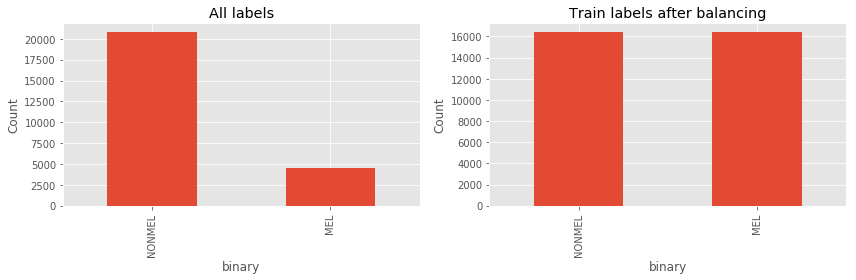

In [16]:
f, axs = plt.subplots(1,2,figsize=(12,4))
# Before balancing
a.binary.value_counts().plot(kind='bar', ax=axs[0])
axs[0].set_title('All labels')
axs[0].set_xlabel('binary')
axs[0].set_ylabel('Count')
# After balancing
Train.binary.value_counts().plot(kind='bar', ax=axs[1])
axs[1].set_title('Train labels after balancing')
axs[1].set_xlabel('binary')
axs[1].set_ylabel('Count')
plt.tight_layout()
plt.show()

## Defining the Image Loader

In [12]:
datagen = ImageDataGenerator(
    rescale = 1/255,
    rotation_range = 270,
    horizontal_flip = True,
    validation_split=00.0)

In [13]:
train_generator=datagen.flow_from_dataframe(
    dataframe=Train,
    directory="./ISIC_2019_Training_Input",
    x_col="image",
    y_col="binary",
    subset="training",
    batch_size=32000,
    shuffle=True,
    class_mode="categorical",
    target_size=(256,256),
    validate_filenames=False)

Found 32906 non-validated image filenames belonging to 2 classes.


## Loading Training Images using Image Loader

In [14]:
small_batch_img, small_batch_lab = train_generator.next()
pd.DataFrame(small_batch_lab)[0].value_counts() / len(small_batch_lab)

0.0    0.500563
1.0    0.499437
Name: 0, dtype: float64

In [31]:
len(small_batch_lab)

32000

## Defining Models for Training

## 1. Baseline Custom Model

In [67]:
input_shape = (256,256,3)
def get_dropout(input_tensor, p=0.5, dr=False):
    if dr:
        return Dropout(p)(input_tensor, training=True)
    else:
        return Dropout(p)(input_tensor)

inp = Input(input_shape)
C1 = Conv2D(24, kernel_size=(3, 3), activation="relu")(inp)
C2= Conv2D(24, kernel_size=(3, 3), activation="relu")(C1)
M1 = MaxPooling2D(pool_size=(2, 2))(C2)
    
C3 = Conv2D(24, kernel_size=(3, 3), activation="relu")(M1)
C4 = Conv2D(24, kernel_size=(3, 3), activation="relu")(C3)
M2 = MaxPooling2D(pool_size=(2, 2))(C4)
    
F1 = Flatten()(M2)
D1 = Dense(100, activation="relu")(F1)
Dr1 = get_dropout(D1, p=0.5, dr=True)
D2 = Dense(100, activation="relu")(Dr1)
out = Dense(2, activation='softmax')(D2)

model = Model(inputs=inp, outputs=out)

model.compile(loss=tf.keras.losses.categorical_crossentropy, 
                  optimizer=tf.keras.optimizers.RMSprop(lr = 0.001),
                  metrics=['accuracy'])

In [71]:
model.summary()

Model: "model_10"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_11 (InputLayer)        [(None, 256, 256, 3)]     0         
_________________________________________________________________
conv2d_16 (Conv2D)           (None, 254, 254, 24)      672       
_________________________________________________________________
conv2d_17 (Conv2D)           (None, 252, 252, 24)      5208      
_________________________________________________________________
max_pooling2d_8 (MaxPooling2 (None, 126, 126, 24)      0         
_________________________________________________________________
conv2d_18 (Conv2D)           (None, 124, 124, 24)      5208      
_________________________________________________________________
conv2d_19 (Conv2D)           (None, 122, 122, 24)      5208      
_________________________________________________________________
max_pooling2d_9 (MaxPooling2 (None, 61, 61, 24)        0  

In [76]:
checkpoint_path = "Deep Learning Project_Dr50/cp.ckpt"
checkpoint_dir = os.path.dirname(checkpoint_path)

# Create checkpoint callback
cp_callback = tf.keras.callbacks.ModelCheckpoint(checkpoint_path, 
                                                 save_weights_only=True,
                                                 verbose=1,
                                                 save_best_only=True)

In [77]:
history = model.fit(small_batch_img,small_batch_lab, epochs = 20, validation_split=.3, callbacks = [cp_callback])

Train on 22400 samples, validate on 9600 samples
Epoch 1/20
22368/22400 [============================>.] - ETA: 1s - loss: 0.5613 - acc: 0.7133
Epoch 00001: val_loss improved from inf to 0.56364, saving model to Deep Learning Project_Dr50/cp.ckpt
22400/22400 [==============================] - 765s 34ms/sample - loss: 0.5612 - acc: 0.7132 - val_loss: 0.5636 - val_acc: 0.6948
Epoch 2/20
22368/22400 [============================>.] - ETA: 1s - loss: 0.5416 - acc: 0.7251
Epoch 00002: val_loss did not improve from 0.56364
22400/22400 [==============================] - 763s 34ms/sample - loss: 0.5416 - acc: 0.7253 - val_loss: 0.5745 - val_acc: 0.6908
Epoch 3/20
22368/22400 [============================>.] - ETA: 1s - loss: 0.5316 - acc: 0.7396
Epoch 00003: val_loss did not improve from 0.56364
22400/22400 [==============================] - 759s 34ms/sample - loss: 0.5318 - acc: 0.7396 - val_loss: 0.6222 - val_acc: 0.6658
Epoch 4/20
22368/22400 [============================>.] - ETA: 1s - los

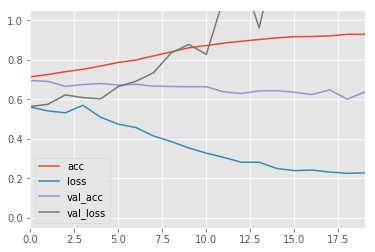

In [82]:
pd.DataFrame(history.history).plot(ylim=(-0.05, 1.05))

In [84]:
saveHist("./Deep Learning Project_Dr50/hist_baseline_dr50_13_12.json",history)

{'val_loss': [0.5636440898974736, 0.5744924357533455, 0.62218142837286, 0.6086617956558863, 0.6023490527272224, 0.6641475534439087, 0.6912568126122157, 0.7340788566072782, 0.8342203157146771, 0.8774791750311851, 0.8273694425821304, 1.1139950590332348, 1.235307744940122, 0.9616025313735008, 1.3456273899475732, 1.3353194797039032, 1.0539596679806709, 1.5817691880464553, 1.2371543342868487, 1.2872823070486386], 'loss': [0.5612233433553151, 0.5415605962702206, 0.5317503063593592, 0.5699073814920017, 0.5093889479126249, 0.47456500044890815, 0.45734329293881143, 0.4146462976293904, 0.3867161838710308, 0.3541145810591323, 0.3277597757641758, 0.30584266844604696, 0.2814216657195772, 0.281553870929139, 0.2500900323955076, 0.23923813080681222, 0.24212360848140504, 0.23225100900179574, 0.22564280558377503, 0.22785485693652716]}


In [78]:
model.save('./Deep Learning Project_Dr50/baseline_dr_1212.h5')

## Defining Transfer Learning Models

## 2. Transfer Learning Model: MobileNet

In [79]:
input_shape = (256,256,3)
def get_dropout(input_tensor, p=0.7, dr=False):
    if dr:
        return Dropout(p)(input_tensor, training=True)
    else:
        return Dropout(p)(input_tensor)

Transfer2 = MobileNet(include_top=False, weights=None, input_shape=(input_shape), pooling="avg")

Dr1tr2 = get_dropout(Transfer2.output, p=0.7, dr=True)

outtr2 = Dense(2, activation='softmax')(Dr1tr2)

model_tr2 = Model(inputs=Transfer2.input, outputs=outtr2)

In [78]:
model_tr2.summary()

Model: "model_7"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_9 (InputLayer)         [(None, 256, 256, 3)]     0         
_________________________________________________________________
conv1_pad (ZeroPadding2D)    (None, 257, 257, 3)       0         
_________________________________________________________________
conv1 (Conv2D)               (None, 128, 128, 32)      864       
_________________________________________________________________
conv1_bn (BatchNormalization (None, 128, 128, 32)      128       
_________________________________________________________________
conv1_relu (ReLU)            (None, 128, 128, 32)      0         
_________________________________________________________________
conv_dw_1 (DepthwiseConv2D)  (None, 128, 128, 32)      288       
_________________________________________________________________
conv_dw_1_bn (BatchNormaliza (None, 128, 128, 32)      128 

In [80]:
model_tr2.compile(loss=tf.keras.losses.categorical_crossentropy,
                  optimizer=tf.keras.optimizers.RMSprop(lr = 0.001),
                  metrics=['accuracy'])

In [81]:
from tensorflow.keras.callbacks import ModelCheckpoint, TensorBoard

In [82]:
checkpoint_path3 = "./Deep Learning Project_Dr50/MobileNet_model_dr50_1212.h5"
checkpoint_dir3 = os.path.dirname(checkpoint_path3)

# Create checkpoint callback
cp_3 = tf.keras.callbacks.ModelCheckpoint(checkpoint_path3, 
                                                 save_weights_only=True,
                                                 verbose=1,
                                         save_best_only=True)

In [84]:
history_tr2 = model_tr2.fit(small_batch_img,small_batch_lab, epochs = 25, 
                            validation_split=.02 ,
                            callbacks = [cp_3], 
                            use_multiprocessing=True,
                            workers=16)

Train on 31360 samples, validate on 640 samples
Epoch 1/25
31328/31360 [============================>.] - ETA: 0s - loss: 0.6366 - acc: 0.6558
Epoch 00001: val_loss improved from inf to 1.73632, saving model to ./Deep Learning Project_Dr50/MobileNet_model_dr50_1212.h5
31360/31360 [==============================] - 249s 8ms/sample - loss: 0.6365 - acc: 0.6558 - val_loss: 1.7363 - val_acc: 0.6125
Epoch 2/25
31328/31360 [============================>.] - ETA: 0s - loss: 0.5678 - acc: 0.6995
Epoch 00002: val_loss improved from 1.73632 to 0.68798, saving model to ./Deep Learning Project_Dr50/MobileNet_model_dr50_1212.h5
31360/31360 [==============================] - 206s 7ms/sample - loss: 0.5677 - acc: 0.6996 - val_loss: 0.6880 - val_acc: 0.7000
Epoch 3/25
31328/31360 [============================>.] - ETA: 0s - loss: 0.5511 - acc: 0.7106
Epoch 00003: val_loss improved from 0.68798 to 0.57456, saving model to ./Deep Learning Project_Dr50/MobileNet_model_dr50_1212.h5
31360/31360 [==========

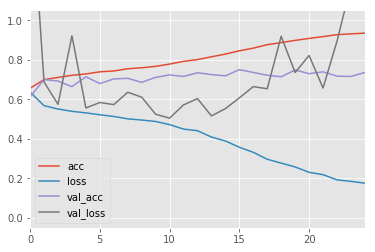

In [85]:
pd.DataFrame(history_tr2.history).plot(ylim=(-0.05, 1.05))

In [86]:
saveHist("./Deep Learning Project_Dr50/hist_Mobile_Net_dr50_13_12.json",history_tr2)

{'val_loss': [1.7363196551799773, 0.6879816949367523, 0.5745605677366257, 0.9212946772575379, 0.5561792030930519, 0.5838689714670181, 0.5732218891382217, 0.6357864230871201, 0.6109531641006469, 0.5246044069528579, 0.504556167125702, 0.571851371973753, 0.6034452423453331, 0.5160355195403099, 0.5527740553021431, 0.6071275636553765, 0.6642371922731399, 0.6534461513161659, 0.9190267786383629, 0.7354451194405556, 0.8220127165317536, 0.6569803118705749, 0.8934402570128441, 1.1776081800460816, 1.0586392641067506], 'loss': [0.636540290926184, 0.567694653570652, 0.5509890192017264, 0.5392861855273344, 0.5314351052958138, 0.5218171263835868, 0.5132824986868975, 0.5011833816766739, 0.4952404673610415, 0.48778132905765453, 0.4720597896192755, 0.44933255783149173, 0.4411035123680319, 0.4091621519047387, 0.389311458542943, 0.35754364777584463, 0.33198369214577333, 0.2968537801990704, 0.27718725256165677, 0.257952796641205, 0.23073226674935038, 0.21898446451606496, 0.19259294279641948, 0.184888540833

In [87]:
model_tr2.save('./Deep Learning Project_Dr50/MobileNet_model_dr50_1212.h5')

## 3. Densenet

In [89]:
input_shape = (256,256,3)
def get_dropout(input_tensor, p=0.5, dr=False):
    if dr:
        return Dropout(p)(input_tensor, training=True)
    else:
        return Dropout(p)(input_tensor)

Transfer3 = DenseNet201(include_top=False, weights=None, input_shape=(input_shape), pooling="avg")

Dr1tr3 = get_dropout(Transfer3.output, p=0.5, dr=True)

outtr3 = Dense(2, activation='softmax')(Dr1tr3)

model_tr3 = Model(inputs=Transfer3.input, outputs=outtr3)

In [ ]:
model_tr3.summary()

In [90]:
model_tr3.compile(loss=tf.keras.losses.binary_crossentropy,
                  optimizer=tf.keras.optimizers.RMSprop(lr = 0.001),
                  metrics=['accuracy'])

In [91]:
checkpoint_path4 = "Deep Learning Project_Dr50/cp_tr3.ckpt"
checkpoint_dir4 = os.path.dirname(checkpoint_path4)

# Create checkpoint callback
cp_4 = tf.keras.callbacks.ModelCheckpoint(checkpoint_path4, 
                                                 save_weights_only=True,
                                                 verbose=1,
                                                 save_best_only=True)

In [92]:
history_tr3 = model_tr3.fit(small_batch_img,small_batch_lab, epochs = 30, validation_split=.02,callbacks = [cp_4])

Instructions for updating:
Use tf.where in 2.0, which has the same broadcast rule as np.where
Train on 31360 samples, validate on 640 samples
Epoch 1/30
31328/31360 [============================>.] - ETA: 0s - loss: 0.6868 - acc: 0.6219
Epoch 00001: val_loss improved from inf to 0.86440, saving model to Deep Learning Project_Dr50/cp_tr3.ckpt
31360/31360 [==============================] - 509s 16ms/sample - loss: 0.6867 - acc: 0.6219 - val_loss: 0.8644 - val_acc: 0.5500
Epoch 2/30
31328/31360 [============================>.] - ETA: 0s - loss: 0.6147 - acc: 0.6646
Epoch 00002: val_loss improved from 0.86440 to 0.64133, saving model to Deep Learning Project_Dr50/cp_tr3.ckpt
31360/31360 [==============================] - 450s 14ms/sample - loss: 0.6148 - acc: 0.6645 - val_loss: 0.6413 - val_acc: 0.6734
Epoch 3/30
31328/31360 [============================>.] - ETA: 0s - loss: 0.5839 - acc: 0.6869
Epoch 00003: val_loss did not improve from 0.64133
31360/31360 [==============================]

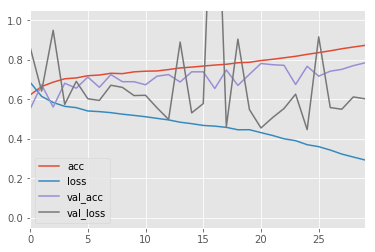

In [93]:
pd.DataFrame(history_tr3.history).plot(ylim=(-0.05, 1.05))

In [94]:
saveHist("./Deep Learning Project_Dr50/hist_DenseNet_dr50_13_12.json",history_tr3)

{'val_loss': [0.8643963366746903, 0.6413264840841293, 0.9490075498819351, 0.5743283808231354, 0.6908340722322464, 0.602883081138134, 0.5944259643554688, 0.6711757078766822, 0.6603144899010658, 0.6190077498555183, 0.6203263163566589, 0.5566921278834343, 0.49801644384860994, 0.8895630955696106, 0.5314019307494163, 0.5783903941512107, 2.1009373486042024, 0.4614749580621719, 0.9043790221214294, 0.548130740225315, 0.45506208539009096, 0.5072066590189934, 0.5536383360624313, 0.6260168954730034, 0.4465343713760376, 0.9161846891045571, 0.558425298333168, 0.5497634083032608, 0.6120559021830558, 0.6025981456041336], 'loss': [0.6866981645932003, 0.6148220500775746, 0.583862676425856, 0.5645109639179949, 0.5577614259963133, 0.54106575557772, 0.5376791398744194, 0.532541288313817, 0.5247317670863502, 0.5185935316949475, 0.5118392782247796, 0.5035883058090599, 0.495821290113488, 0.48411354303968196, 0.47679032222652923, 0.4679076957155247, 0.46426273219439446, 0.4581334619345714, 0.4459043020800668,

In [95]:
model_tr3.save('./Deep Learning Project_Dr50/DenseNet_model_dr50_13_12.h5')

## 4. NASnet

In [112]:
input_shape = (256,256,3)
def get_dropout(input_tensor, p=0.5, dr=False):
    if dr:
        return Dropout(p)(input_tensor, training=True)
    else:
        return Dropout(p)(input_tensor)

Transfer5 = NASNetMobile(include_top=False, weights=None, input_shape=(input_shape), pooling="avg")

Dr1tr5 = get_dropout(Transfer5.output, p=0.5, dr=True)

outtr5 = Dense(2, activation='softmax')(Dr1tr5)

model_tr5 = Model(inputs=Transfer5.input, outputs=outtr5)

In [ ]:
model_tr5.summary()

In [113]:
model_tr5.compile(loss=tf.keras.losses.binary_crossentropy,
                  optimizer=tf.keras.optimizers.RMSprop(lr = 0.001),
                  metrics=['accuracy'])

In [114]:
checkpoint_path6 = "Deep Learning Project_Dr50/cp_tr5.ckpt"
checkpoint_dir6 = os.path.dirname(checkpoint_path6)

# Create checkpoint callback
cp_6 = tf.keras.callbacks.ModelCheckpoint(checkpoint_path6, 
                                                 save_weights_only=True,
                                                 verbose=1,
                                                 save_best_only=True)

In [115]:
history_tr5 = model_tr5.fit(small_batch_img,small_batch_lab, epochs = 30, validation_split=.02,callbacks = [cp_6])

Train on 31360 samples, validate on 640 samples
Epoch 1/30
31328/31360 [============================>.] - ETA: 0s - loss: 0.6546 - acc: 0.6546
Epoch 00001: val_loss improved from inf to 8.04978, saving model to Deep Learning Project_Dr50/cp_tr5.ckpt
31360/31360 [==============================] - 523s 17ms/sample - loss: 0.6546 - acc: 0.6546 - val_loss: 8.0498 - val_acc: 0.4750
Epoch 2/30
31328/31360 [============================>.] - ETA: 0s - loss: 0.5600 - acc: 0.7101
Epoch 00002: val_loss improved from 8.04978 to 5.54229, saving model to Deep Learning Project_Dr50/cp_tr5.ckpt
31360/31360 [==============================] - 447s 14ms/sample - loss: 0.5601 - acc: 0.7099 - val_loss: 5.5423 - val_acc: 0.5109
Epoch 3/30
31328/31360 [============================>.] - ETA: 0s - loss: 0.5376 - acc: 0.7197
Epoch 00003: val_loss did not improve from 5.54229
31360/31360 [==============================] - 447s 14ms/sample - loss: 0.5377 - acc: 0.7196 - val_loss: 7.9522 - val_acc: 0.4781
Epoch 4/

In [116]:
saveHist("./Deep Learning Project_Dr50/hist_NASnet_dr50_13_12.json",history_tr5)

{'val_loss': [8.049780368804932, 5.542293095588684, 7.9521548509597775, 8.065898370742797, 8.051974129676818, 8.051974201202393, 8.092869281768799, 8.051974272727966, 8.051974081993103, 8.051974153518676, 8.051974105834962, 8.051974153518676, 8.051974105834962, 8.051974129676818, 8.004045772552491, 7.8602605104446415, 7.309083604812622, 7.980081510543823, 7.773639833927154, 7.558733940124512, 7.708694124221802, 5.678972148895264, 5.007622802257538, 6.936751985549927, 6.495344853401184, 6.622478985786438, 5.140525019168853, 5.262354946136474, 4.94990781545639, 4.372266709804535], 'loss': [0.6545844205179993, 0.5601054620681977, 0.537706907093525, 0.5267911911010742, 0.5191669177340001, 0.5095796070840894, 0.5058026734967621, 0.5013471445866994, 0.49298883351136225, 0.4913844686685776, 0.4776368732203026, 0.4754148923012675, 0.4781215810045904, 0.4589597723465793, 0.6356131964800309, 0.4604223044399096, 0.4539662169710714, 0.48097249667863456, 0.461259372319494, 0.4626900433885808, 0.421

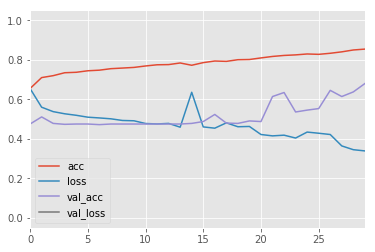

In [117]:
pd.DataFrame(history_tr5.history).plot(ylim=(-0.05, 1.05))

In [121]:
model_tr5.save('./Deep Learning Project_Dr50/NASnet_model_dr50_13_12.h5')

## Clearly, The DenseNet Model is performing the best. Training it further to fine tune its accuracy

# Densenet_Final

In [21]:
input_shape = (256,256,3)
def get_dropout(input_tensor, p=0.5, dr=False):
    if dr:
        return Dropout(p)(input_tensor, training=True)
    else:
        return Dropout(p)(input_tensor)

Transfer_final = DenseNet201(include_top=False, weights=None, input_shape=(input_shape), pooling="avg")

Dr1tr_final = get_dropout(Transfer_final.output, p=0.5, dr=True)

outtr_final = Dense(2, activation='softmax')(Dr1tr_final)
model_tr_final = Model(inputs=Transfer_final.input, outputs=outtr_final)

Instructions for updating:
If using Keras pass *_constraint arguments to layers.


In [27]:
model_tr_final.summary()

Model: "model"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            [(None, 256, 256, 3) 0                                            
__________________________________________________________________________________________________
zero_padding2d (ZeroPadding2D)  (None, 262, 262, 3)  0           input_1[0][0]                    
__________________________________________________________________________________________________
conv1/conv (Conv2D)             (None, 128, 128, 64) 9408        zero_padding2d[0][0]             
__________________________________________________________________________________________________
conv1/bn (BatchNormalization)   (None, 128, 128, 64) 256         conv1/conv[0][0]                 
______________________________________________________________________________________________

In [28]:
model_tr_final.compile(loss=tf.keras.losses.binary_crossentropy,
                  optimizer=tf.keras.optimizers.RMSprop(lr = 0.001),
                  metrics=['accuracy'])

In [29]:
checkpoint_path_final = "Deep Learning Project_Dr50/cp_tr_final.ckpt"
checkpoint_dir_final = os.path.dirname(checkpoint_path_final)

# Create checkpoint callback
cp__final = tf.keras.callbacks.ModelCheckpoint(checkpoint_path_final, 
                                                 save_weights_only=True,
                                                 verbose=1,
                                                 save_best_only=True)

In [33]:
history_tr_final = model_tr_final.fit(small_batch_img,small_batch_lab, epochs = 5, validation_split=.02,callbacks = [cp__final])

Train on 31360 samples, validate on 640 samples
Epoch 1/5
31328/31360 [============================>.] - ETA: 0s - loss: 0.1686 - acc: 0.9339
Epoch 00001: val_loss did not improve from 0.49038
31360/31360 [==============================] - 447s 14ms/sample - loss: 0.1685 - acc: 0.9339 - val_loss: 0.8748 - val_acc: 0.7625
Epoch 2/5
31328/31360 [============================>.] - ETA: 0s - loss: 0.1571 - acc: 0.9386
Epoch 00002: val_loss did not improve from 0.49038
31360/31360 [==============================] - 447s 14ms/sample - loss: 0.1569 - acc: 0.9386 - val_loss: 0.8862 - val_acc: 0.7797
Epoch 3/5
31328/31360 [============================>.] - ETA: 0s - loss: 0.1548 - acc: 0.9410
Epoch 00003: val_loss did not improve from 0.49038
31360/31360 [==============================] - 446s 14ms/sample - loss: 0.1547 - acc: 0.9410 - val_loss: 0.7561 - val_acc: 0.7766
Epoch 4/5
31328/31360 [============================>.] - ETA: 0s - loss: 0.1379 - acc: 0.9472
Epoch 00004: val_loss did not imp

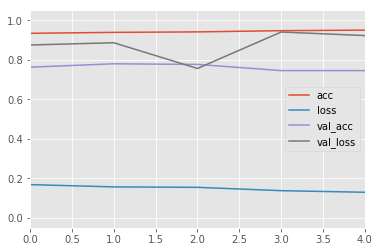

In [34]:
pd.DataFrame(history_tr_final.history).plot(ylim=(-0.05, 1.05))

In [35]:
saveHist("./Deep Learning Project_Dr50/hist_DenseNet_dr_final_50_13_12.json",history_tr_final)

{'loss': [0.16851772544240312, 0.15692507116105028, 0.15472904640744078, 0.13791150735139998, 0.12973925242989268], 'val_loss': [0.87479297965765, 0.8861830189824105, 0.7561151906847954, 0.9403895854949951, 0.9224588736891747]}


In [36]:
model_tr_final.save('./Deep Learning Project_Dr50/DenseNet_model_dr_final_50_13_12.h5')